In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from scipy.odr import *

# Might wanna remove this if things get hairy
import warnings
warnings.filterwarnings('ignore')


def non_trivialize_df(df):
    # Search columns for trivial feature (virus)
    dropped = 0
    for idx, col in enumerate(df.columns):
        uniques = df[col].unique()
        num_unique = len(uniques)
        if num_unique == 1 and 'sera_table' not in col and "*" in uniques: # Critereon for a missing virus
#             print(idx, col, num_unique, uniques)
            df = df.drop(columns=col)
            dropped += 1 # Count dropped virus
    # Search rows for trivial entry (serum)
    for idx in list(df.index):
        num_unique = len(df.loc[idx].unique())
        if num_unique == 3: # Serum name and table name are 2 constant features.
#             print(idx, num_unique)
            df = df.drop(index=idx)
    df = df.replace("*", np.nan)
    df = df.set_index('Measurements (Sera in Rows/Viruses in Columns)')
    df = df.drop(['sera_table'], axis=1)
    df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
    # Return data and number of dropped viruses
    return df, dropped


def plot_heatmap(df):
    mask = df.isnull()
    g = sns.heatmap(df, cmap='gray',mask=mask)
    g.set_facecolor('xkcd:salmon')
    return g


def plot_heatmap_subplot(table_dict):
#     keys = sorted(list(table_dict.keys()))
    keys = ["TableS1", "TableS3", "TableS5", "TableS6", "TableS13", "TableS14"]
    N = len(keys)
    fig, axs = plt.subplots(nrows=1, ncols=N, figsize=(30, 5))
    for idx, key in enumerate(keys):
        df, dropped_viruses = table_dict[key]
        percent_missing = sum(list(df.isna().sum())) / (df.shape[0] * df.shape[1]) # Proportion of missing vals in table
        df = np.log10(df)
        sera_num = df.shape[0]
        virus_num = df.shape[1]
        mask = df.isnull()
        g = sns.heatmap(df,
                        xticklabels=False,
                        yticklabels=False,
                        cmap='gray',
                        mask=mask,
                        ax=axs[idx])
        g.set_facecolor('xkcd:salmon')
        axs[idx].set_xlabel(f'{sera_num} Sera x {virus_num} Viruses\n{percent_missing * 100:.2f}% Missing')
        axs[idx].set_title(key)
    return fig, axs

In [2]:
def train_tree(target_table: "pd.DataFrame",
               source_tables: "list(pd.DataFrame)",
               feature_t: "str",
               selected_viruses_list: "bool OR list(str)" = False,
               n_feature = 5,
               f_sample=0.3,
               k=1,
               comparison_name=None):
    '''
    Function performs:
    - Data cleaning to ensure that viruses have sufficient sera data
    - Selection of virus features which are found in training dataset
    - Virus Selection: selected_viruses_list can be either False for random virus selection or a list of viruses

    Output:
    - For a single target virus, output a list containing:
        - dtr
        - RMSE
        - cross_RMSE
        - virus_col_sel
        - feature_t
        
    Assumptions:
    - This function should be interchangeable with an ensemble tree trainer
    - Target virus which the tree has been trained on is found in training data
        - Cannot train a tree to predict a virus otherwise!
    - Each source table is used for training a tree and finding its
      associated cross-validation RMSE. Table which you want to make
      predictions on is also required so that trees can be trained 
      with relevant viruses.
    - target_table should be a dataframe where columns are viruses
      and row indices are seras. The value for each virus-serum pair
      is an HAI score for binding.
    - tables source_tables are analagous to target_table in structure
    - When talking about cross-validation RMSE,
      I train a tree on data (5 selected viruses X subset of sera) and make predictions
      on testing/validating data (5 selected viruses X all viable sera that weren't used for training).
      I believe that I am cross validating on Sera as selected viruses remain constant
      accuracy of a tree trained on
    '''
#     np.random.seed(42) # Random seed selection # Ummm, setting random seed will make all trees of a target train on the same viruses (really bad lol)

    '''
    Data Preprocessing:
    
    (1) Renaming testing data and training data: data_t, data_assist_train
    (2) Create list of virus names which are covered by >80% of sera in training data, excluding target feature virus: f_col_ind_train
        - To be used for selecting usable features in training data
    (3*) Create list of virus names which intersect training data and f_col_ind_train (viruses covered by >80% of sera): f_tmp_ind
        - Might be redundant
    (3) Create list of virus names which have more than 2 sera values in testing data: f_feasible
        - Honestly sounds a little arbitrary, but it is in Rong's R code 
    (4) Create list of virus names which are found in both f_col_ind_train and testing data: f_feasible
        - To be used for selecting usable features in both training and testing data that we can feasibly test 
            - Only these intersecting featuers will work for: 
                1.) finding cross validation RMSE (RMSE)
                2.) evaluating tree performance on testing data i.e. finding cross table RMSE (cross_RMSE)
    (5) Drop all sera (rows) which have NAN values for the target feature virus (feature_t): data_assist_train
        - This is the only real change to any data table so far (training data)
    '''
    tree_dict = dict() # Will contain trained tree, cross-validation RMSE, and (truth, predictions) for cross validation 
    for idx, train_table in enumerate(source_tables):
        # Renaming testing data (data_t) and training data (data_assist_train)
        data_t = target_table # (1) Data that we want to make prediction on 
        data_assist_train = train_table # (1) Main dataframe used in training and validation (Perform log10 transform)
        # Choose viruses that are covered by 80% of sera 
        if (data_assist_train.apply(lambda x: x.count(), axis=0) / data_assist_train.shape[0] > 0.8).sum() > n_feature:
            # f_col_ind_train should be a list of viruses covered by >80% of sera
            f_col_ind_train = list(data_assist_train.columns[(data_assist_train.apply(lambda x: x.count(), axis=0) / data_assist_train.shape[0] > 0.8).tolist()]) # (2) Only consider viruses that are covered by > 80% of sera in study
            if feature_t in f_col_ind_train: # Exclude target feature virus
                f_col_ind_train.remove(feature_t) # (2)
        else:
            print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        f_tmp_ind = [data_t.columns.get_loc(col) for col in f_col_ind_train if col in data_t.columns] # (3*) Find indices of columns that intersect f_col_ind_train and data_t
        f_feasible = [col for col in data_t.columns[f_tmp_ind] if data_t[col].count() > 2] # (3) Choose viruses that have more than 2 sera values in prediction data
        f_col_ind_train = [col for col in f_col_ind_train if col in f_feasible] # (4) Intersects cols from f_feasible and f_col_ind_train
        if len(f_feasible) < 2:
            print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        data_assist_train = data_assist_train.dropna(subset=[feature_t]) # (5) Drops NAs in training data for target

        '''
        Training:
        
        Training conditions: Perform checks on validity of training data
        (1) Training dataset must have sera binding data on target virus
        (2) Target feature is in training data (only way target dataset error (cross_RMSE) can be computed)
        '''
        if data_assist_train.shape[0] == 0: # (1)
            return
        if feature_t in data_t:
            if sum(np.isnan(data_t[feature_t])) == len(data_t[feature_t]): # (2)
    #                print(f"sum(np.isnan(data_t[feature_t])): {sum(np.isnan(data_t[feature_t]))}")
                return
        else:
    #         print(f"{feature_t} not in data_t")
            return
        # Training step (and single cross validation):
        if selected_viruses_list: # If selected_viruses_list is not False, I'm assuming its just a list of virus names
            virus_col_sel = np.array(selected_viruses_list) # Viruses we specifically want to train on and use for predictions in predicting data
        else:
            features_list = list(data_assist_train.columns) # Make sure feature_t isn't in features to train on
            features_list.remove(feature_t)
            virus_col_sel = np.random.choice(f_feasible, n_feature, replace=True)

        sera_row_sel = np.random.choice(data_assist_train.shape[0], int(data_assist_train.shape[0] * f_sample), replace=True) # Randomly selected sera
        # We want to include the column of f_t_ind into our data_train
        data_train = data_assist_train.iloc[sera_row_sel][np.append(virus_col_sel, feature_t)] # Training data subset covering virus_col_sel viruses and sera_row_sel sera
        col_mean_t = data_train.apply(lambda x: x.mean(), axis=1) # Prepare to mean center the training data
        data_train = data_train - np.outer(np.ones(data_train.shape[1]), col_mean_t).T # Mean center the training data
        data_train.columns = np.append(virus_col_sel, "target")
        dtr = DecisionTreeRegressor(min_samples_split=5)
        dtr.fit(data_train.iloc[:, :-1], data_train["target"]) # Train on selected viruses and sera, evaluate with target virus
        # Compile validation dataset, really performing a single cross validation (evaluate on data complementary to training data)
        data_test = data_assist_train.drop([data_assist_train.index[idx] for idx in sera_row_sel], axis=0)[np.append(virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
        col_mean_t = data_test.apply(lambda x: x.mean(), axis=1)
        data_test = data_test - np.outer(np.ones(data_test.shape[1]), col_mean_t).T
        pred_t = dtr.predict(data_test.iloc[:, :-1]) # Make prediction on target using unforeseen data
        RMSE = np.sqrt(np.mean((pred_t - data_test[feature_t]) ** 2))

        # Compile testing dataset using data_t for cross-table RMSC
        cross_virus_col_sel = virus_col_sel # Viruses we specifically want to train on and use for predictions in predicting data
        cross_sera_row_sel = np.random.choice(data_t.shape[0], int(data_t.shape[0] * f_sample), replace=True) # Randomly selected sera        data_test = data_assist_train.drop([data_assist_train.index[idx] for idx in sera_row_sel], axis=0)[np.append(virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
        cross_data_test = data_t[np.append(cross_virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
        cross_col_mean_t = cross_data_test.apply(lambda x: x.mean(), axis=1)
        cross_data_test = cross_data_test - np.outer(np.ones(cross_data_test.shape[1]), cross_col_mean_t).T
        cross_pred_t = dtr.predict(cross_data_test.iloc[:, :-1]) # Make prediction on target using unforeseen data

        # OKOKOK, we can only find cross_RMSE if target table actually contains target feature...
        cross_RMSE = np.sqrt(np.mean((cross_pred_t - cross_data_test[feature_t]) ** 2)) 
        if np.isnan(cross_RMSE):
            '''
            Problems with cross_data_test[feature_t]
            - Select better viruses to train on! Likely reason for failure is that im not choosing trainable viruses
            '''
            print("Problem with computing cross_RMSE!!!")
            print(cross_virus_col_sel)
            print(cross_data_test)
            print("PREDICTIONS:")
            print(cross_pred_t)
            print()
    return [dtr, RMSE, cross_RMSE, virus_col_sel, feature_t, cross_pred_t, comparison_name]
    

In [3]:
def m_best_trees_trainer(target_table: "pd.DataFrame",
                         source_tables: "list(pd.DataFrame)",
                         feature_t: "str",
                         selected_viruses_list: "bool OR list(str)" = False,
                         n_feature = 5,
                         f_sample=0.3,
                         train_trees=10,
                         best_trees=5,
                         k=1,
                         comparison_name=None):
    '''
    This function will call the subroutine N number of times to generate N trees, from which the M best may be selected/returned
    Might also want to store a list of the target + training viruses for each tree made (might be like a bar code or signature)
    Once a bunch of trees are returned for the comparison between the target and training datasets (including a map from "tree name" : "list of involved viruses")
    we may compute an error line for each training virus in the comparison plot. With this Error line, we have our means of computing the worst case error of a 
    prediction.
    '''
    train_tree_list_list = [] # A single train_tree_list_list corresponds to the current target virus
    for i in range(train_trees): # Make some trees
        train_tree_list = train_tree(target_table = target_table,
                                     source_tables = source_tables,
                                     feature_t = feature_t,
                                     selected_viruses_list = selected_viruses_list,
                                     n_feature = n_feature,
                                     f_sample = f_sample,
                                     k = k,
                                     comparison_name=comparison_name)
        if train_tree_list is None:
#             print("NONE???")
            return train_tree_list
        dtr, RMSE, cross_RMSE, virus_col_sel, feature_t, cross_pred_t, comparison_name = train_tree_list
        train_tree_list_list.append(train_tree_list)
    # Rank trees in descending order by cross validation RMSE (training error, not cross table RMSE which iis cross_RMSE)
    train_tree_list_list = sorted(train_tree_list_list, key = lambda x:x[1]) 
    return train_tree_list_list[:best_trees]
    

In [4]:
'''
data_t: DF of sera (table specific) X Viruses (No viruses dropped yet) to make prediction on
data_s_list: list of columns of data table for virus to train on ... Its the whole df I think
feature_t: A particular virus to predict (And I assume we omit this from training)
n_tree=50
n_feature=5
f_sample=0.3
n_best_tree=5
'''

flu_df = pd.read_csv("../CrossStudyCompletion/Matrix Completion in R/InfluenzaData.csv", sep=',')
sera = flu_df['Measurements (Sera in Rows/Viruses in Columns)'].tolist()
sera_tables = [i[i.index('Table'):] for i in sera]
table_keys = set(sera_tables)
flu_df['sera_table'] = sera_tables

flu_table_dict = {table_key: flu_df.loc[flu_df['sera_table']==table_key] for table_key in table_keys}
filtered_flu_table_dict = {key: non_trivialize_df(arg) for key, arg in list(flu_table_dict.items())}

predict_table = 'TableS14'
train_table = 'TableS13'
data_df = flu_df.set_index("Measurements (Sera in Rows/Viruses in Columns)")
data_df = data_df.applymap(lambda x: pd.to_numeric(x, errors='coerce') )
data_df = np.log10(data_df)
data_df['sera_table'] = sera_tables

data_t = data_df.loc[data_df['sera_table']==predict_table].drop(['sera_table'], axis=1)
data_s = data_df.loc[data_df['sera_table']==train_table].drop(['sera_table'], axis=1)
data_s_list = [data_s] # [[col] for col in list(data_s.columns)]
feature_t = "A/PANAMA/2007/99"

# Creating Figure S1

### Notes:
- Somethings up with "HN196/2009" ?
    - Apparently its only found in tables S1 and S3
    - Could we do a weird network thing where we impute values for the rest of the tables (S5, S5, S13, S14) by
      finding which tables are most immediately transferable with each other? Might be cool way of forming a DAG
      to satisfy missing values between tables (or naive lol)
      
- Issue with computing Cross RMSEs for some viruses
    - Could be insufficient sera which are feasible for training?

In [7]:
tableS1  = data_df.loc[data_df['sera_table']=="TableS1"].drop(['sera_table'], axis=1)
tableS3  = data_df.loc[data_df['sera_table']=="TableS3"].drop(['sera_table'], axis=1)
tableS5  = data_df.loc[data_df['sera_table']=="TableS5"].drop(['sera_table'], axis=1)
tableS6  = data_df.loc[data_df['sera_table']=="TableS6"].drop(['sera_table'], axis=1)
tableS13 = data_df.loc[data_df['sera_table']=="TableS13"].drop(['sera_table'], axis=1)
tableS14 = data_df.loc[data_df['sera_table']=="TableS14"].drop(['sera_table'], axis=1)
# table_names = ["tableS1" , "tableS3" , "tableS5" , "tableS6" , "tableS13", "tableS14"]
# table_list = [tableS1 , tableS3 , tableS5 , tableS6 , tableS13, tableS14]
table_names = ["tableS5" , "tableS6" , "tableS13" , "tableS14" , "tableS3", "tableS1"]
table_list = [tableS5 , tableS6 , tableS13 , tableS14 , tableS3, tableS1]
table_dict = {table_names[idx]: table_list[idx] for idx in range(len(table_names))}
comparison_dict = dict()
for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            tree_dict = dict() # Contains {trees and RMSE data} collected from training a tree on target features of target_table
            # Preparing tree parameters
            feature_targets = list(target_table.columns) # List of viruses to make a tree/prediction on
            for i, feature_target in enumerate(feature_targets): # Make a tree for each virus in target_table if virus in source_table
                if feature_target in source_table.columns:
                    train_tree_list = train_tree(
                                                target_table=target_table,
                                                source_tables=[source_table], # Feed in a list containing our single source table (functionality on multiple source tables is intended (WIP))
                                                selected_viruses_list=False, # Set selected_viruses_list to false to randomly select viruses to train on
                                                feature_t=feature_target,
                                                comparison_name=comparison_name)
                else:
                    print(f"{table_names[idx]} does not contain {feature_target} which {table_names[jdx]} seeks!")
                if train_tree_list is not None and len(train_tree_list) != 0:
                    tree_dict[feature_target] = train_tree_list
            comparison_dict[comparison_name] = tree_dict
#             print("----------------")
            print(f"Comparison from {source_table_name} to {target_table_name} completed")


Comparison from tableS5 to tableS6 completed
Comparison from tableS5 to tableS13 completed
Comparison from tableS5 to tableS14 completed
Comparison from tableS5 to tableS3 completed
Comparison from tableS5 to tableS1 completed
Comparison from tableS6 to tableS5 completed
Comparison from tableS6 to tableS13 completed
Comparison from tableS6 to tableS14 completed
Comparison from tableS6 to tableS3 completed
Comparison from tableS6 to tableS1 completed
Comparison from tableS13 to tableS5 completed
Comparison from tableS13 to tableS6 completed
Comparison from tableS13 to tableS14 completed
Comparison from tableS13 to tableS3 completed
Comparison from tableS13 to tableS1 completed
Comparison from tableS14 to tableS5 completed
Comparison from tableS14 to tableS6 completed
Comparison from tableS14 to tableS13 completed
Comparison from tableS14 to tableS3 completed
Comparison from tableS14 to tableS1 completed
Comparison from tableS3 to tableS5 completed
Comparison from tableS3 to tableS6 comp

In [8]:
print("Number of comparisons: ", len(comparison_dict))
print("Number of trees in comparison: ", len(tree_dict))


Number of comparisons:  30
Number of trees in comparison:  50


In [9]:
comparison_dict
intra_RMSE_dict = dict()
cross_RMSE_dict = dict()
for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            intra_RMSE_data = []
            cross_RMSE_data = []
            for target in list(comparison_dict[comparison_name].keys()):
                tree_data = comparison_dict[comparison_name][target] # Assuming that only one source table was used in training tree
                intra_RMSE_data.append(tree_data[1])
                cross_RMSE_data.append(tree_data[2])
            intra_RMSE_dict[comparison_name] = intra_RMSE_data
            cross_RMSE_dict[comparison_name] = cross_RMSE_data

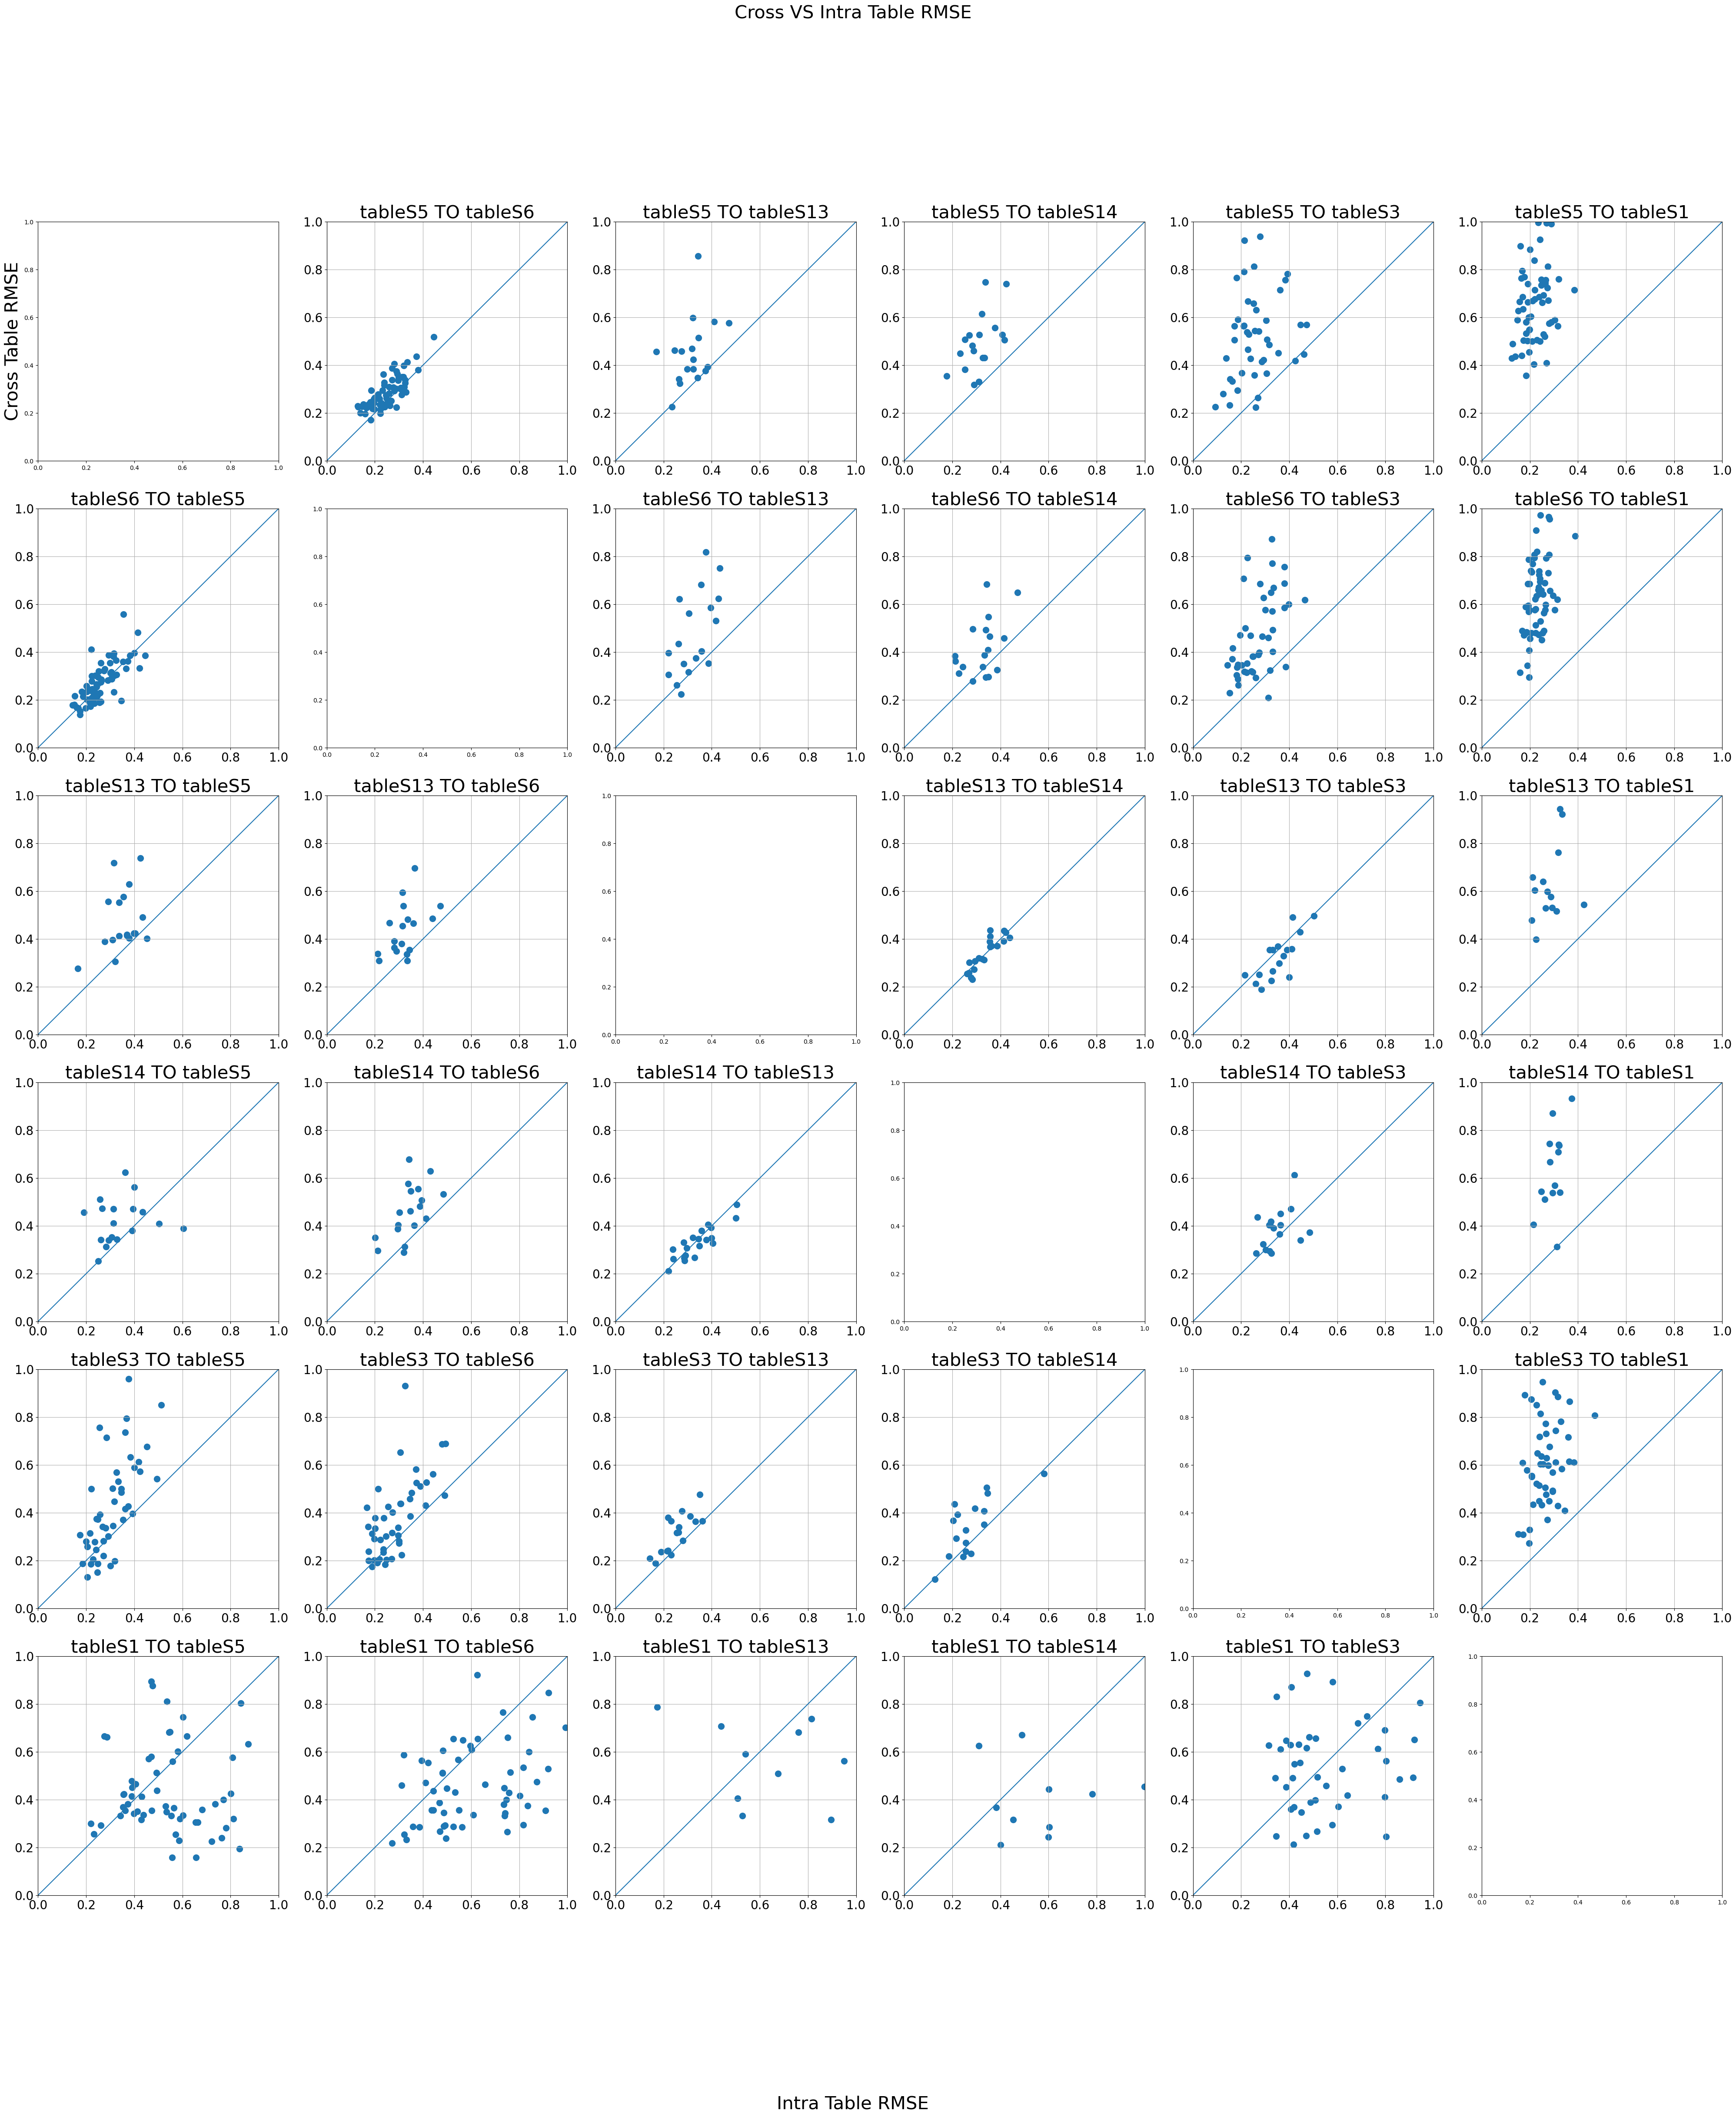

In [ ]:
'''
Questions:

- When finding the cross RMSE:
    - Dataset is the whole target dataset, selected on 5 randomly selected feasible viruses
    - If the target virus has all NANs, my cross RMSE is NAN because of RMSE formula.
        - Should I only choose target viruses that have non-NAN values?
'''

nrows, ncols = len(table_names), len(table_names)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50, 50))

for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            
            x = intra_RMSE_dict[comparison_name]
            y = cross_RMSE_dict[comparison_name]

            axs[idx, jdx].scatter(x,y, s=100)
            axs[idx, jdx].set_title(comparison_name, fontsize = 30)
            axs[0,0].set_ylabel("Cross Table RMSE", fontsize = 30)
            axs[idx, jdx].tick_params(axis='both', which='major', labelsize=20)
            axs[idx, jdx].grid()
            axs[idx, jdx].plot([0, 1], [0, 1], transform=axs[idx, jdx].transAxes)
            axs[idx, jdx].set_xlim([0, 1])
            axs[idx, jdx].set_ylim([0, 1])
        fig.suptitle("Cross VS Intra Table RMSE", fontsize=30)
        fig.supxlabel('Intra Table RMSE', fontsize=30)

In [ ]:
dtr_list_S13_S14 = comparison_dict['tableS13 TO tableS14']['A/PANAMA/2007/99']

a = ['A/PERTH/27/2007', 'A/PERTH/16/2009', 'A/TASMANIA/1/97', 'NL/620/89', 'A/PERTH/16/2009']
a.append(dtr_list_S13_S14[4])
tableS14[a]


,A/PERTH/27/2007,A/PERTH/16/2009,A/TASMANIA/1/97,NL/620/89,A/PERTH/16/2009,A/PANAMA/2007/99
Measurements (Sera in Rows/Viruses in Columns),,,,,,
SubjectB007_Pre_TableS14,1.00000,1.30103,0.69897,1.00000,1.30103,0.69897
SubjectB024_Pre_TableS14,1.60206,1.30103,1.00000,0.69897,1.30103,1.60206
SubjectA003_Pre_TableS14,1.60206,1.30103,0.69897,1.60206,1.30103,0.69897
SubjectB004_Pre_TableS14,1.30103,1.30103,0.69897,1.00000,1.30103,1.30103
SubjectB028_Pre_TableS14,1.00000,0.69897,1.30103,1.60206,0.69897,1.30103
...,...,...,...,...,...,...
SubjectA028_Post_TableS14,1.30103,2.20412,2.20412,1.90309,2.20412,2.50515
SubjectA020_Post_TableS14,1.00000,0.69897,1.30103,1.90309,0.69897,2.20412
SubjectB025_Post_TableS14,1.00000,1.30103,2.20412,0.69897,1.30103,2.50515


In [12]:
dtr_list_S13_S14

[DecisionTreeRegressor(min_samples_split=5),
 0.2773718216378272,
 0.2385112433067423,
 array(['NL/233/82', 'A/VICTORIA/110/2004', 'NL/620/89',
        'A/FUJIAN/140/2000', 'A/TASMANIA/1/97'], dtype='<U19'),
 'A/PANAMA/2007/99',
 array([-1.50514998e-01,  5.01716659e-02, -5.01716659e-01,  4.18097216e-01,
        -1.11022302e-16,  3.13572912e-01,  4.18097216e-01, -2.00686664e-01,
        -5.01716659e-01, -1.50514998e-01,  4.18097216e-01, -1.50514998e-01,
        -2.00686664e-01, -2.50858330e-01,  4.18097216e-01,  1.00343332e-01,
         1.00343332e-01, -2.00686664e-01,  2.50858330e-01, -1.50514998e-01,
        -1.50514998e-01, -1.11022302e-16, -2.50858330e-01,  4.51544993e-01,
        -2.00686664e-01, -1.11022302e-16,  4.18097216e-01,  5.01716659e-02,
        -2.50858330e-01,  2.50858330e-01, -1.50514998e-01,  5.01716659e-02,
         3.13572912e-01, -2.00686664e-01, -5.01716659e-01, -5.01716659e-01,
        -1.11022302e-16,  3.13572912e-01, -1.11022302e-16, -5.01716659e-01,
         2.

In [13]:
'''
HUGE PROBLEM (Actually Im overreacting):
- When there are duplicate viruses in training, BAD COMPLICATIONS occur in indexing (Actually might not be too bad at all)
'''

df = tableS14
dtr_list_S13_S14 = comparison_dict['tableS13 TO tableS14']['A/PANAMA/2007/99']

n_feature = 1

def convert_raw_dtr_predictions(data, dtr_list):
    '''
    Input for trained decision trees must be log10 transformed
    and mean centered HAI values corresponding to the {n_feautes}
    virus featues which the decision tree was trained on. 
    
    Data should be the table which a prediction will be made from.
    
    Output will be HAI values that will essentially be mean_centered
    and log10 transformed. Due to this, in order to retrieve actual
    HAI values, these transformations must be reversed.
    '''
    dtr = dtr_list[0]
    col_select = dtr_list[3].tolist() # np.random.choice(df.columns, 5)
    target = dtr_list[4]
    col_select.append(target)
    data_select_target = data[col_select] # Might not need to drop NANs
    data_select = data_select_target.iloc[:,:-1]
#     print(data_select)
    col_mean_t = data_select.apply(lambda x: x.mean(), axis=1)
    data_select = data_select - np.outer(np.ones(data_select.shape[1]), col_mean_t).T
    pred_t = dtr.predict(data_select.to_numpy()) # Make prediction on target using unforeseen data
    pred_t_uncentered = pred_t + col_mean_t

    HAI_predictions = 10**(pred_t_uncentered)
    HAI_measurements = 10**data_select_target[target]
#     print(HAI_measurements)
    return HAI_predictions.to_numpy().reshape(1, -1), HAI_measurements.to_numpy().reshape(1, -1), pred_t

def average_convert_raw_dtr_predictions(data, dtr_lists_list):
    HAI_predictions_list = []
    for dtr_list in dtr_lists_list:
        HAI_predictions, HAI_measurements, raw_predictions = convert_raw_dtr_predictions(data=data, dtr_list=dtr_list)
        HAI_predictions_list.append(HAI_predictions)
    
    HAI_predictions_df = pd.DataFrame()
    for idx, i in enumerate(HAI_predictions_list):
        HAI_predictions_df[idx] = i.tolist()[0]
    mu = HAI_predictions_df.mean(axis=1)
    return mu, HAI_measurements, HAI_predictions_df, raw_predictions
    
        
# data_select_target = convert_raw_dtr_predictions(data=tableS14, dtr_list=dtr_list_S13_S14) 
# HAI_predictions, HAI_measurements, raw_predictions = convert_raw_dtr_predictions(data=tableS14, dtr_list=dtr_list_S13_S14) 

In [14]:
df = pd.DataFrame()


df['y']=np.log10(HAI_predictions.tolist()[0])
df['x']=np.log10(HAI_measurements.tolist()[0])
sns.scatterplot(df, x='x', y='y')

NameError: name 'HAI_predictions' is not defined

# TODO:
- [DONE] Get function to train 10 trees and output the 5 best trees (Outputs N trees, chooses K best trees) for each virus in a dataset
    - Essentially, do everything that Figure 2 says
    - Incorporate thise into figure S1 to mimic Tal's original fig   
    - COOL VISUAL: Giant heatmap that shows all datasets overlapping with missing values in pink
        - After imputation of missing values, plot another heatmap
- [DONE, BUT NOT AS DESCRIBED] Make a class or something to create a perpendicularly fit line on datapoints taken from Cross VS Intra RMSE comparisons of 2 samples
    - For each virus point, a new line should be fit on points that are not used for training the virus tree (Including the virus itself)
    - Perpendicular line fit should also be used past the point where x=y is 1 or something (look at the plot lol)
- [DONE]  Once each virus in table comparisons has a computed line, worst case errors for each virus based on their (1) specific tree and (2) Intra RMSE can be computed
- [DONE] Bayesian averages of V_ij +- sigma_ij can then be coputed


In [130]:
train_trees = 50
best_trees = 20

tableS1  = data_df.loc[data_df['sera_table']=="TableS1"].drop(['sera_table'], axis=1)
tableS3  = data_df.loc[data_df['sera_table']=="TableS3"].drop(['sera_table'], axis=1)
tableS5  = data_df.loc[data_df['sera_table']=="TableS5"].drop(['sera_table'], axis=1)
tableS6  = data_df.loc[data_df['sera_table']=="TableS6"].drop(['sera_table'], axis=1)
tableS13 = data_df.loc[data_df['sera_table']=="TableS13"].drop(['sera_table'], axis=1)
tableS14 = data_df.loc[data_df['sera_table']=="TableS14"].drop(['sera_table'], axis=1)
# table_names = ["tableS1" , "tableS3" , "tableS5" , "tableS6" , "tableS13", "tableS14"]
# table_list = [tableS1 , tableS3 , tableS5 , tableS6 , tableS13, tableS14]

# Short versions
table_names = ["tableS13" , "tableS14" , "tableS3", "tableS1"]
table_list = [tableS13 , tableS14 , tableS3, tableS1]

# table_names = ["tableS5" , "tableS6" , "tableS13" , "tableS14" , "tableS3", "tableS1"]
# table_list = [tableS5 , tableS6 , tableS13 , tableS14 , tableS3, tableS1]

comparison_dict = dict()
for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            tree_dict = dict() # Contains {trees and RMSE data} collected from training a tree on target features of target_table
            # Preparing tree parameters
            feature_targets = list(target_table.columns) # List of viruses to make a tree/prediction on
            for i, feature_target in enumerate(feature_targets): # Make a tree for each virus in target_table if virus in source_table
                if feature_target in source_table.columns:
                    train_tree_list = m_best_trees_trainer(target_table = target_table,
                                                           source_tables = [source_table],
                                                           feature_t = feature_target,
                                                           selected_viruses_list = False,
                                                           n_feature = 5,
                                                           f_sample=0.3,
                                                           train_trees=train_trees,
                                                           best_trees=best_trees,
                                                           k=1,
                                                           comparison_name=comparison_name)
                else:
                    print(f"{table_names[idx]} does not contain {feature_target} which {table_names[jdx]} seeks!")
                if train_tree_list is not None and len(train_tree_list) != 0:
                    tree_dict[feature_target] = train_tree_list
            comparison_dict[comparison_name] = tree_dict
#             print("----------------")
            print(f"Comparison from {source_table_name} to {target_table_name} completed")


Comparison from tableS13 to tableS14 completed
Comparison from tableS13 to tableS3 completed
Comparison from tableS13 to tableS1 completed
Comparison from tableS14 to tableS13 completed
Comparison from tableS14 to tableS3 completed
Comparison from tableS14 to tableS1 completed
Comparison from tableS3 to tableS13 completed
Comparison from tableS3 to tableS14 completed
Comparison from tableS3 to tableS1 completed
Comparison from tableS1 to tableS13 completed
Comparison from tableS1 to tableS14 completed
Comparison from tableS1 to tableS3 completed


In [132]:

intra_RMSE_dict = dict()
cross_RMSE_dict = dict()
for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            intra_RMSE_data = []
            cross_RMSE_data = []
            for target in list(comparison_dict[comparison_name].keys()):
                tree_data = comparison_dict[comparison_name][target] # Assuming that only one source table was used in training tree
                for l in tree_data:
                    intra_RMSE_data.append(l[1])
                    cross_RMSE_data.append(l[2])
            intra_RMSE_dict[comparison_name] = intra_RMSE_data
            cross_RMSE_dict[comparison_name] = cross_RMSE_data

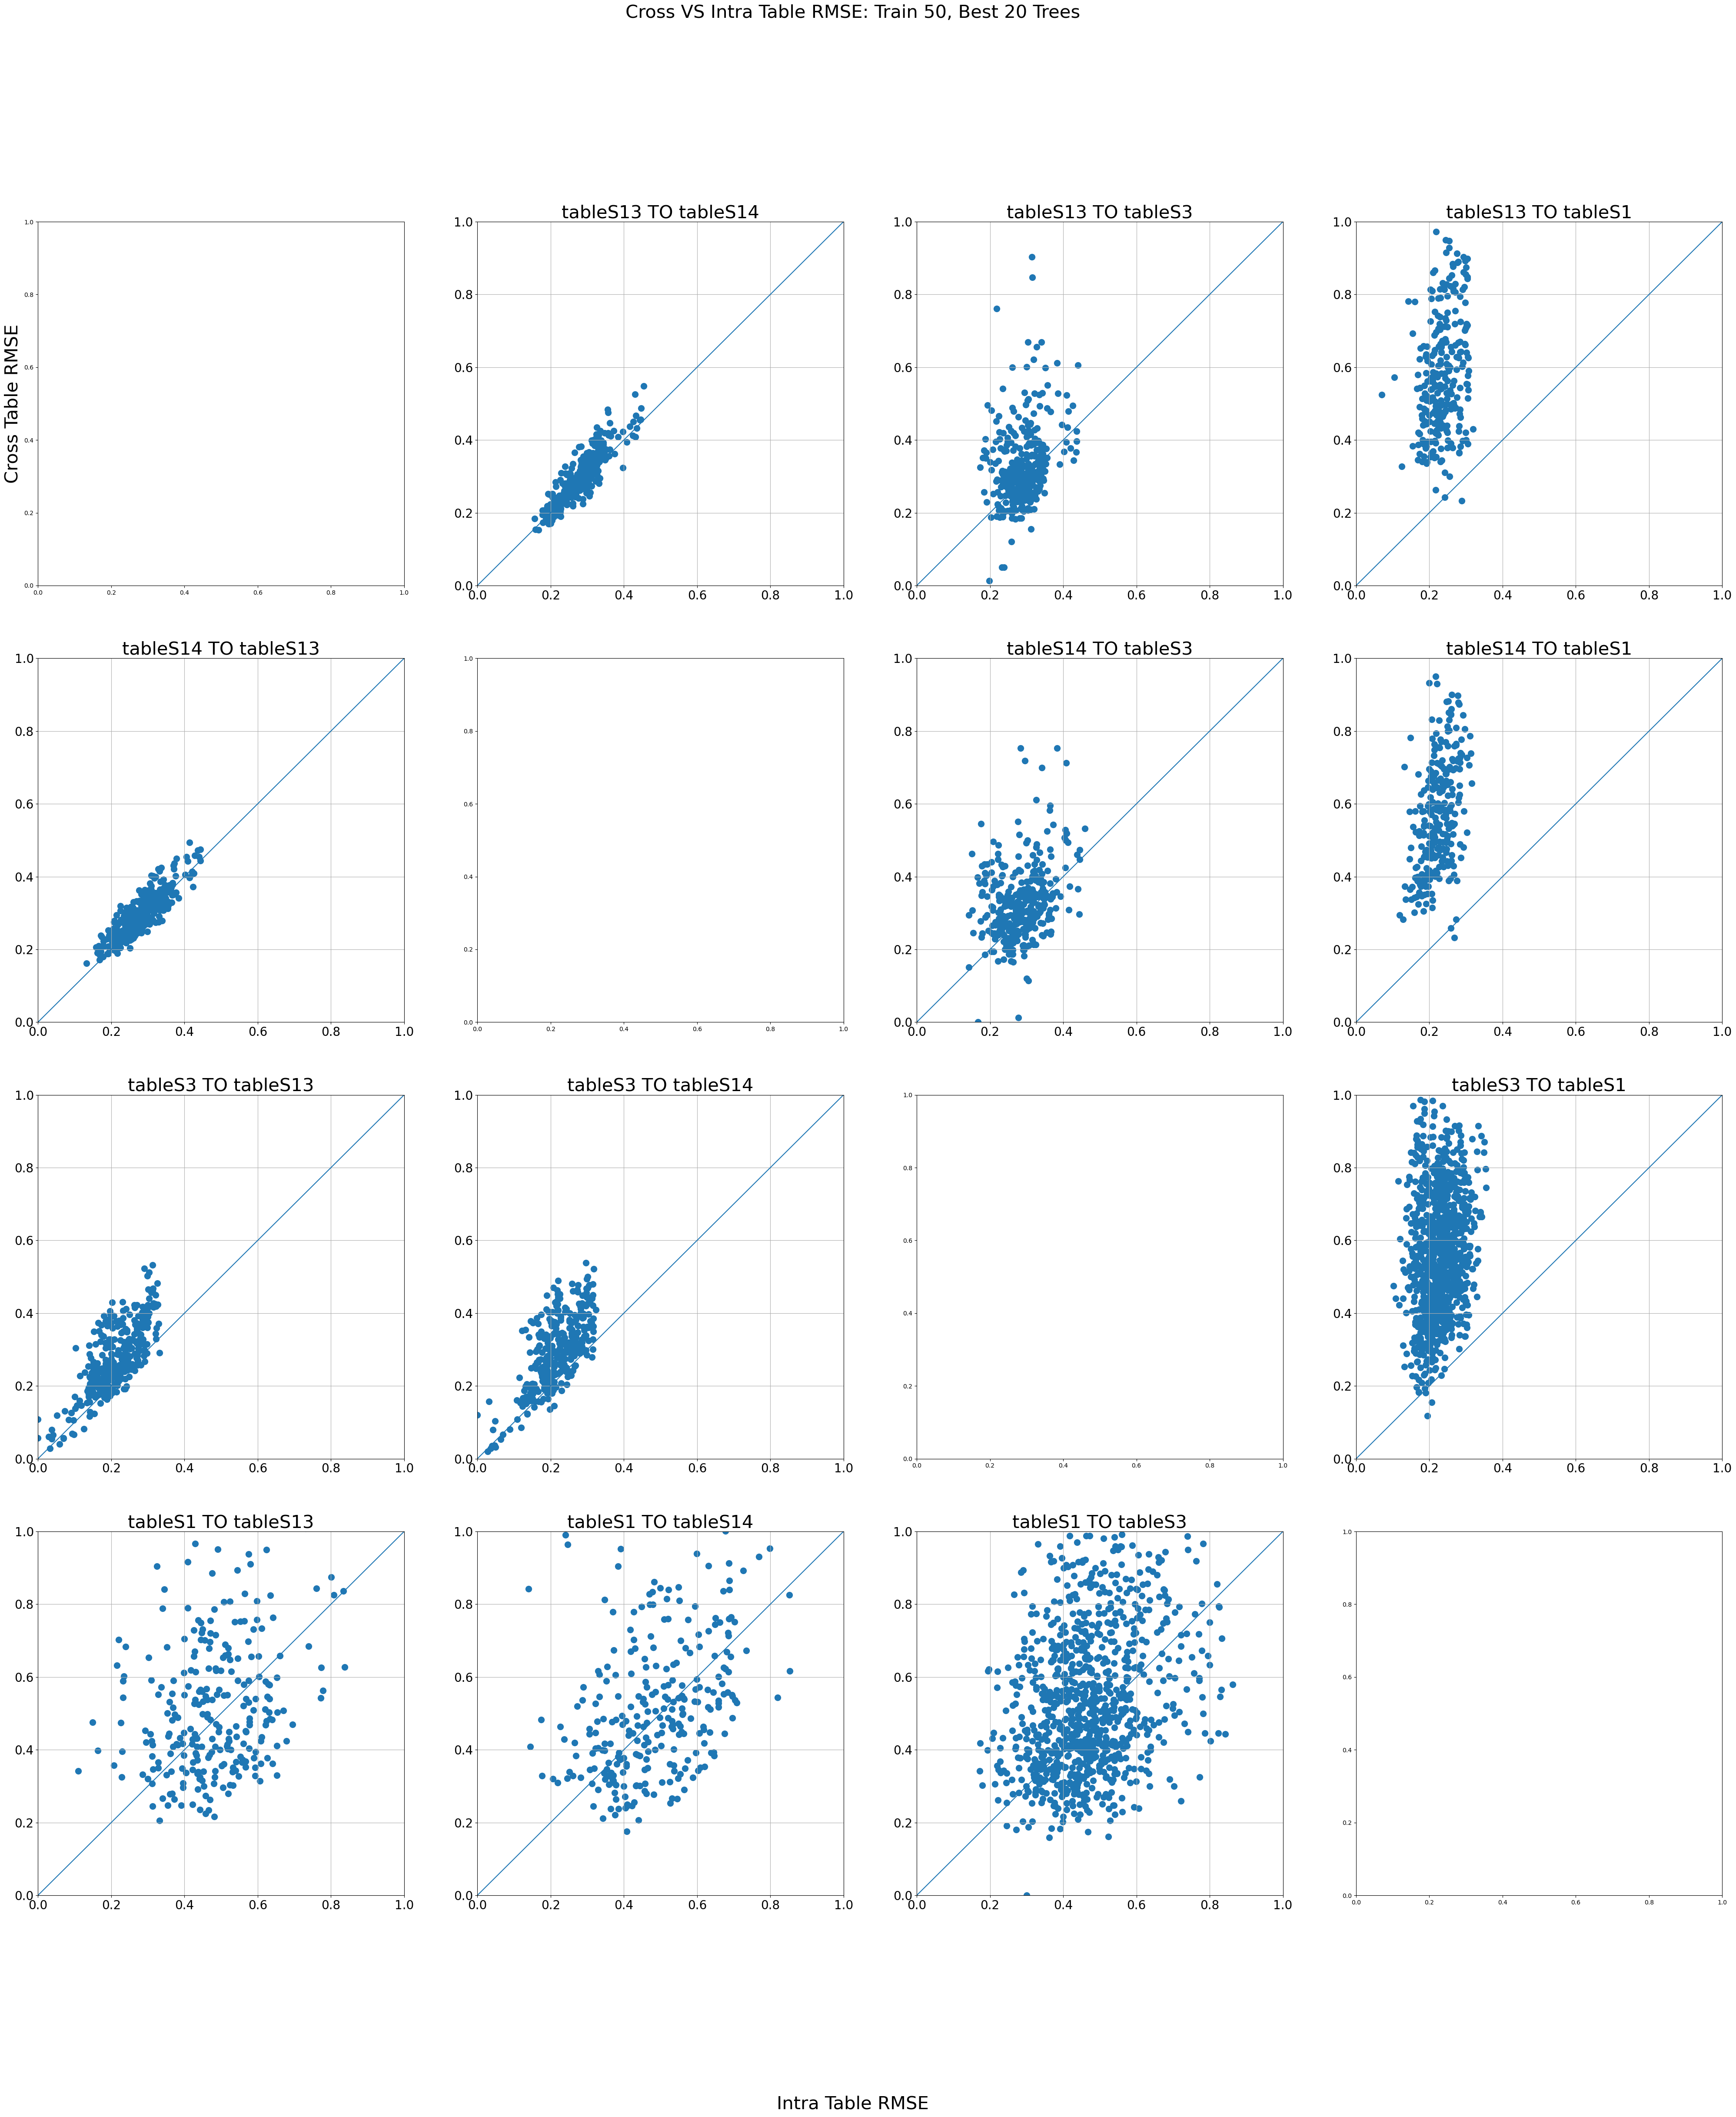

In [ ]:
'''
Questions:
- When finding the cross RMSE:
    - Dataset is the whole target dataset, selected on 5 randomly selected feasible viruses
    - If the target virus has all NANs, my cross RMSE is NAN because of RMSE formula.
        - Should I only choose target viruses that have non-NAN values?
'''

nrows, ncols = len(table_names), len(table_names)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50, 50))

for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            
            x = intra_RMSE_dict[comparison_name]
            y = cross_RMSE_dict[comparison_name]

            axs[idx, jdx].scatter(x,y, s=100)
            axs[idx, jdx].set_title(comparison_name, fontsize = 30)
            axs[0,0].set_ylabel("Cross Table RMSE", fontsize = 30)
            axs[idx, jdx].tick_params(axis='both', which='major', labelsize=20)
            axs[idx, jdx].grid()
            axs[idx, jdx].plot([0, 1], [0, 1], transform=axs[idx, jdx].transAxes)
            axs[idx, jdx].set_xlim([0, 1])
            axs[idx, jdx].set_ylim([0, 1])
        fig.suptitle(f"Cross VS Intra Table RMSE: Train {train_trees}, Best {best_trees} Trees", fontsize=30)
        fig.supxlabel('Intra Table RMSE', fontsize=30)
        
fig.savefig(f"Cross VS Intra Table RMSE: Train {train_trees}, Best {best_trees} Trees")

In [134]:
comparison_dict.keys()

dict_keys(['tableS13 TO tableS14', 'tableS13 TO tableS3', 'tableS13 TO tableS1', 'tableS14 TO tableS13', 'tableS14 TO tableS3', 'tableS14 TO tableS1', 'tableS3 TO tableS13', 'tableS3 TO tableS14', 'tableS3 TO tableS1', 'tableS1 TO tableS13', 'tableS1 TO tableS14', 'tableS1 TO tableS3'])

# Construct Perpendicularly Fit Lines (ODRs) for Each Virus

In [135]:
'''
Read Box 1 and Box 2 for more info on what to do next...

SUPER IMPORTANT!!!!
!!! Box 2 has info on what to keep after training a tree !!!

Make something that can:

for each comparison (other dataset is D_j):
    for each virus (V_j_i):
        1.)
            - select all virus points within current comparison which (in order to prevent "double dipping"):
                (1) Aren't the current target virus
                (2) Don't use any of the viruses used to train the tree for the current target virus
            - With selected points, train a ODR line for current target virus
            - SIGMA_j: Assign virus name an ODR line using a dict?
        2.)
            - MU_j: Find Bayesian Average of predicted value (relies on SIGMA_j)
    - Assign a comparison a virus2ODR dict
'''
def odr_model(params, x):
    a, b = params
    return a * x + b


def find_odr_fitted_params(x_data, y_data, odr_model):
    # Find ODR or perpendicularly fit line on current set of points
    x_data, y_data = sigma_training_list, sigma_actual_list
    data = RealData(x_data, y_data)
    model = Model(odr_model)
    initial_guess = [1.0, 1.0]  # Initial guess for the parameters
    odr = ODR(data, model, beta0=initial_guess)
    result = odr.run()
    fitted_params = result.beta # Slope and bias parameters for ODR
    return fitted_params

def worst_case_error(RMSE, odr_model, fitted_params):
    '''
    Function takes in RMSE, odr model, and trained/fitted parameters.
    Function then returns the max between the RMSE and the error predicted
    from inputting RMSE into the trained odr model.
    
    Assume that RMSE is a list or array
    '''
    output = []
    for idx in range(len(RMSE)):
        odr_value = odr_model(fitted_params, RMSE[idx])
        output.append(max(RMSE[idx], odr_value))
    return output

# list(comparison_dict['tableS5 TO tableS6'].keys())[0]
comparison_name = 'tableS3 TO tableS1'

comparison_virus_ODR_df_dict = dict() # Will contain all ODR models
for comparison_name in comparison_dict.keys():
    print(f"{comparison_name}: Extracting ODR datapoints and training ODR per virus")
    virus_ODR_df_dict = dict()
    for v_j_i in comparison_dict[comparison_name].keys():
#         print(v_j_i)
        sigma_training_list = []
        sigma_actual_list = []
    #     points_list = [] # Exclude points from trees trained on target virus
        unacceptable_features = [] # If tree was trained on any of these features, don't consider it for ODR
        df = pd.DataFrame()
        for idx, v_j_i_tree in enumerate(comparison_dict[comparison_name][v_j_i]): # Iterate over trained tree lists given by train_tree function
#             sigma_training = v_j_i_tree[1]
#             sigma_actual = v_j_i_tree[2]
            training_features = v_j_i_tree[3]
            target_feature = v_j_i_tree[4]
    #         unacceptable_features.extend(training_features) # Not sure if this counts as double dipping
            unacceptable_features.append(target_feature)

        for v_j_i_inner in comparison_dict[comparison_name].keys(): # Iterate over all other viruses
            if v_j_i != v_j_i_inner: # Only consider viruses which aren't the target for finding ODR
                for idx_inner, v_j_i_tree_inner in enumerate(comparison_dict[comparison_name][v_j_i_inner]): # Iterate over trained tree lists given by train_tree function
                    sigma_training = v_j_i_tree_inner[1]
                    sigma_actual = v_j_i_tree_inner[2]
                    training_features = v_j_i_tree_inner[3]
                    target_feature = v_j_i_tree_inner[4]
    #                 print(f"target_feature not in unacceptable_feature: {target_feature not in unacceptable_features}")
    #                 print(f"not any([feature in unacceptable_features for feature in training_features]): {not any([feature in unacceptable_features for feature in training_features])}")
                    if target_feature not in unacceptable_features and not any([feature in unacceptable_features for feature in training_features]):
                        sigma_training_list.append(sigma_training)
                        sigma_actual_list.append(sigma_actual)

        # Find ODR or perpendicularly fit line on current set of points
#         x_data, y_data = sigma_training_list, sigma_actual_list
#         data = RealData(x_data, y_data)
#         model = Model(odr_model)
#         initial_guess = [1.0, 1.0]  # Initial guess for the parameters
#         odr = ODR(data, model, beta0=initial_guess)
#         result = odr.run()
#         fitted_params = result.beta # Slope and bias parameters for ODR
        fitted_params = find_odr_fitted_params(x_data=sigma_training_list, 
                                               y_data=sigma_actual_list,
                                               odr_model=odr_model)
        # Construct dataframe with sigma_training, sigma_actual, and worst case error predicted from ODR
        df['sigma_training'] = sigma_training_list
        df['sigma_actual'] = sigma_actual_list
        df['worst_case_error'] = worst_case_error(sigma_training_list, odr_model, fitted_params)
        virus_ODR_df_dict[v_j_i] = (df, odr_model, fitted_params) # Might not need odr_model function as an arg if I make it a global function
    comparison_virus_ODR_df_dict[comparison_name] = virus_ODR_df_dict



tableS13 TO tableS14: Extracting ODR datapoints and training ODR per virus
tableS13 TO tableS3: Extracting ODR datapoints and training ODR per virus
tableS13 TO tableS1: Extracting ODR datapoints and training ODR per virus
tableS14 TO tableS13: Extracting ODR datapoints and training ODR per virus
tableS14 TO tableS3: Extracting ODR datapoints and training ODR per virus
tableS14 TO tableS1: Extracting ODR datapoints and training ODR per virus
tableS3 TO tableS13: Extracting ODR datapoints and training ODR per virus
tableS3 TO tableS14: Extracting ODR datapoints and training ODR per virus
tableS3 TO tableS1: Extracting ODR datapoints and training ODR per virus
tableS1 TO tableS13: Extracting ODR datapoints and training ODR per virus
tableS1 TO tableS14: Extracting ODR datapoints and training ODR per virus
tableS1 TO tableS3: Extracting ODR datapoints and training ODR per virus


In [136]:
from scipy.odr import *

comparison_name = "tableS13 TO tableS14"
sample_name = 'A/AUCKLAND/5/96'
data = comparison_virus_ODR_df_dict['tableS13 TO tableS14']['A/AUCKLAND/5/96'][0]  # Replace with the path to your data file
x_data = data['sigma_training']
y_data = data['sigma_actual']
data = RealData(x_data, y_data)
model = Model(odr_model)
initial_guess = [1.0, 1.0]  # Initial guess for the parameters
odr = ODR(data, model, beta0=initial_guess)
result = odr.run()
fitted_params = result.beta


In [137]:
def plot_ODR(comparison_name, sample_name, comparison_virus_ODR_df_dict, train_trees, best_trees):
    '''
    Function plots out ODR line trained on datapoints relevant to a target virus's tree RMSE values
    '''
    fig = plt.figure()
    ODR_df_dict = comparison_virus_ODR_df_dict[comparison_name][sample_name]
    odr_model = ODR_df_dict[1]
    fitted_params = ODR_df_dict[-1]
    # Use ODR model to retrieve worst case errors
    x_values = np.linspace(0, 1, 100)
    y_values = worst_case_error(x_values, odr_model, fitted_params)
    # Retrieve simga_training and sigma_acutal relevant to virus
    x_data = ODR_df_dict[0]['sigma_training']
    y_data =  ODR_df_dict[0]['sigma_actual']
    # Plot data points
    sns.scatterplot(x=x_data, y=y_data, label="Data")
    # Add the ODR model line to the plot
    sns.lineplot(x=x_values, y=y_values, label=f"ODR Model", color='red')
    
    # Set labels, title, and legend
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"ODR Model Fitted Line: Train {train_trees}, Best {best_trees} trees;\n{comparison_name} Sample {sample_name}")
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    sns.lineplot(x=[0, 1], y=[0, 1], label="Diagonal Line (y = x)", linestyle='--', color='green')

    # Display the plot
    plt.savefig(f"ODR Model: Train {train_trees}, Best {best_trees} trees: {comparison_name} Sample {sample_name.replace('/', '_')}")
    return fig


# Perform antibody response averages ($\mu_{j} \pm \sigma_{j}$)

## Notes:
- Training more trees makes predictions closer to measurements
    - When training 

Text(0.5, 1.0, 'HAI Measurements VS Predictions: Train 50, Best 20')

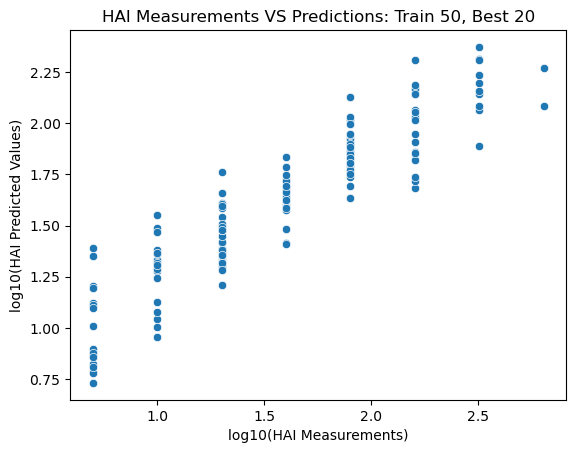

In [138]:
data = tableS14
dtr_lists_list = comparison_dict['tableS13 TO tableS14']['A/PANAMA/2007/99']

mu, HAI_measurements, HAI_predictions_df, raw_predictions = average_convert_raw_dtr_predictions(data, dtr_lists_list)

df = pd.DataFrame()
df['y']=np.log10(mu.tolist())
df['x']=np.log10(HAI_measurements.tolist()[0])


sns.scatterplot(df, x='x', y='y')
plt.xlabel("log10(HAI Measurements)")
plt.ylabel("log10(HAI Predicted Values)")
plt.title(f"HAI Measurements VS Predictions: Train {train_trees}, Best {best_trees}")
# plt.savefig(f"HAI Measurements VS Predictions: Train {train_trees}, Best {best_trees}")

In [139]:
# comparison_dict

Text(0.5, 1.0, 'HAI Measurements VS Predictions with error bars:\nTrain 50, Best 20, sigma = [0.2541053392471032]')

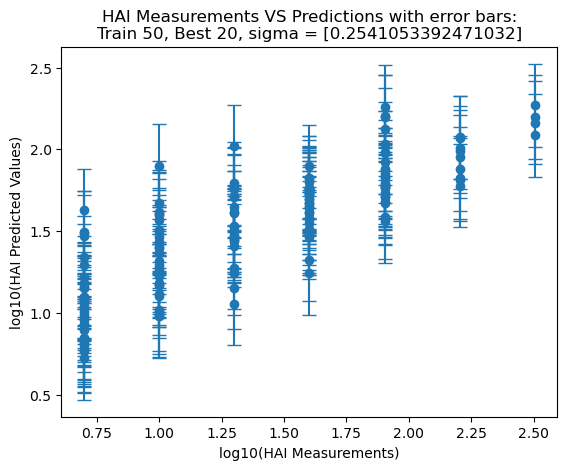

In [140]:
'''
QUESTIONS:
- To convert these values back to normal HAI values, I'm assuming I just reverse the log10 transform. However, when I
  do this, my values look very different from the fig on the paper. Otherwise, they look almost identical to Rong's code.
  Is Figure 3 in log2 scale? It kinda looks like it.
  
- What are the error bars on the figure in terms of? In my code, 10**error is the predicted error as n-folds. Is my error
  right then (this mirrors Rong's code)?
  
GET CLARIFICATION ON COMBINING DATASETS:
- Say I have trained trees on single datasets (this is how I recreated S1), would combining datasets just mean taking
  the weighted averages (Bayesian average) of trees trained on different datasets?
  
NOTES:
- For ODR, I only exclude tree RMSEs (training and testing) if they include the target virus in their training. However
  I keep trees which contain any of the viruses which were used to train the trees for the target virus (might be double dipping).
'''
data = tableS14
comparison_name = 'tableS13 TO tableS14'
virus_name = 'A/AUCKLAND/5/96'


dtr_lists_list = comparison_dict[comparison_name][virus_name] # Retrieve tree data for a specific comparison on a specific virus
df, odr_model, fitted_params = comparison_virus_ODR_df_dict[comparison_name][virus_name] # Retrieve ODR for a specific comparison on a specific virus
mu, HAI_measurements, HAI_predictions_df, raw_predictions = average_convert_raw_dtr_predictions(data, dtr_lists_list) # Find AVG HAI preds and measurements
# Find error for each HAI prediction using ODR
sigma_training_list = [i[1] for i in dtr_lists_list] # See Box 1 section 2 for reasoning
mean_sigma_training = sum(sigma_training_list)/len(sigma_training_list) # Take mean
error = worst_case_error(RMSE = [mean_sigma_training], odr_model = odr_model, fitted_params = fitted_params) # Find worst case error
error_actual = 10**np.sqrt(np.nanmean((np.log10(HAI_measurements.flatten()) - np.log10(mu.to_numpy()))**2))

# Plot data
x = np.log10(HAI_measurements.tolist()[0])
y = np.log10(mu.tolist())
errors = error * len(x)



plt.errorbar(x=x, y=y, yerr=errors, fmt='o', capsize=5)
plt.xlabel("log10(HAI Measurements)")
plt.ylabel("log10(HAI Predicted Values)")
plt.title(f"HAI Measurements VS Predictions with error bars:\nTrain {train_trees}, Best {best_trees}, sigma = {error}")
# plt.savefig(f"HAI Measurements VS Predictions with error bars: Train {train_trees}, Best {best_trees}")

# Combining Datasets according to Equation 1 

In [141]:
table_names

['tableS13', 'tableS14', 'tableS3', 'tableS1']

In [142]:
table_dict = {table_names[idx]: table_list[idx] for idx in range(len(table_names))}

In [143]:
'''
NOTES:
- Might want to ensure all dfs contain sera names as indices!
    - Acutally, assuming that the target table determines the number of predictions
      made, indexing might not be necessary!
    - e.g. We have 2 comparisons "tableS1 TO tableS6" and "tableS5 TO tableS6",
      both will end up having 160 predictions each since there are 160 predictable viruses
      in tableS6
    - Still might wanna index for clarity's sake
'''

comparison_combiner_dict = dict() # This dict is needed for combining Box 1 part 3

for comparison_idx, comparison_name in enumerate(list(comparison_dict.keys())): # Choose comparison
    comparison_combiner_dict[comparison_name] = dict()
    source_table, _, target_table = comparison_name.split(" ") # Find source and target tables of comparison
    for virus_idx, virus_name in enumerate(list(comparison_dict[comparison_name].keys())): # Choose target virus in comparison
        data = table_dict[target_table]
        # Retrieve decision tree, ODR model, and predictions
        dtr_lists_list = comparison_dict[comparison_name][virus_name] # Retrieve decision tree data
        df, odr_model, fitted_params = comparison_virus_ODR_df_dict[comparison_name][virus_name] # Retrieve ODR
        mu, HAI_measurements, HAI_predictions_df, raw_predictions = average_convert_raw_dtr_predictions(data, dtr_lists_list) # Find AVG HAI preds and measurements        
        # Find error for each HAI prediction using ODR
        sigma_training_list = [i[1] for i in dtr_lists_list] # See Box 1 section 2 for reasoning
        mean_sigma_training = sum(sigma_training_list)/len(sigma_training_list) # Take mean
        error_predict = worst_case_error(RMSE = [mean_sigma_training], odr_model = odr_model, fitted_params = fitted_params) # Find worst case error
        error_actual = 10**np.sqrt(np.nanmean((np.log10(HAI_measurements.flatten()) - np.log10(mu.to_numpy()))**2))
        # Error bar data (Warning: Only valid for viruses with HAI measurements)
        x = np.log10(HAI_measurements.tolist()[0])
        y = np.log10(mu.tolist())
        errors = error_predict * len(x)
        # Note that viruses without HAI measurements to begin with won't have valid error bar data
        comparison_combiner_dict[comparison_name][virus_name] = {
            'mu': mu,
            'error_predict_actual': (error_predict, error_actual),
            'error_bar_data': (x, y, errors)
        }

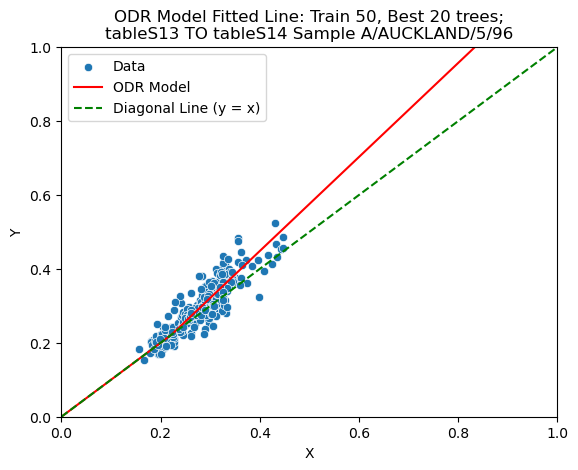

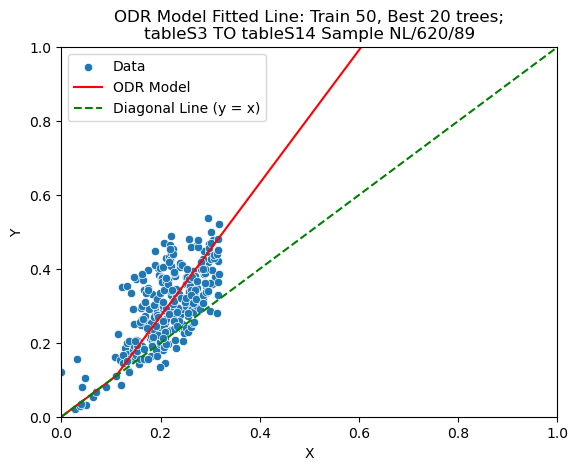

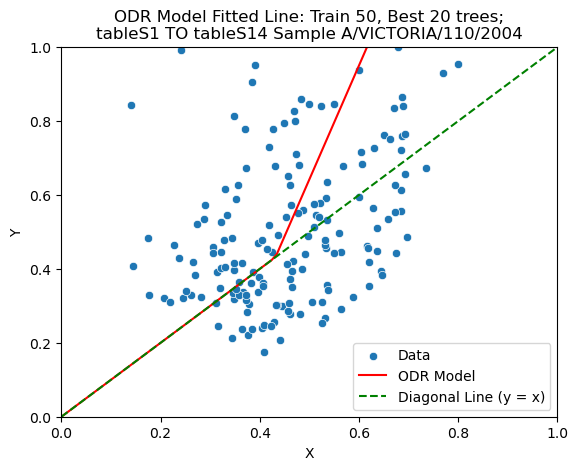

In [144]:
a = plot_ODR(comparison_name='tableS13 TO tableS14',
             sample_name='A/AUCKLAND/5/96',
             comparison_virus_ODR_df_dict=comparison_virus_ODR_df_dict,
             train_trees=train_trees,
             best_trees=best_trees)
b = plot_ODR(comparison_name='tableS3 TO tableS14',
             sample_name='NL/620/89',
             comparison_virus_ODR_df_dict=comparison_virus_ODR_df_dict,
             train_trees=train_trees,
             best_trees=best_trees)
c = plot_ODR(comparison_name='tableS1 TO tableS14',
             sample_name='A/VICTORIA/110/2004',
             comparison_virus_ODR_df_dict=comparison_virus_ODR_df_dict,
             train_trees=train_trees,
             best_trees=best_trees)

Text(0.5, 0, '$\\dfrac{|M-\\mu|}{\\sigma}$')

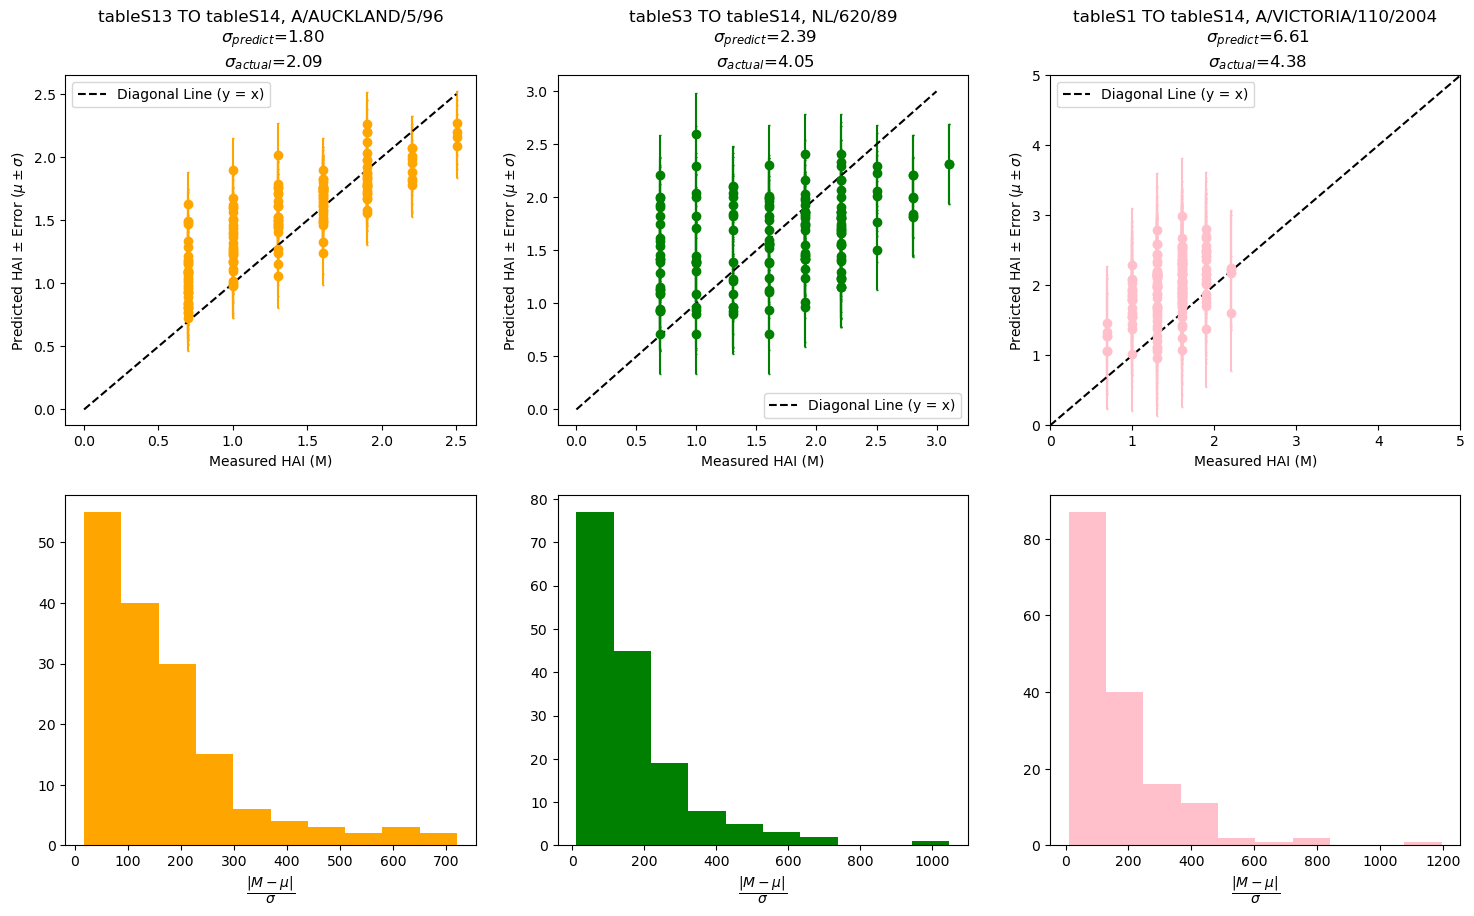

In [145]:


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,10))

mu0 = comparison_combiner_dict['tableS13 TO tableS14']['A/AUCKLAND/5/96']['mu']
error_predict0, error_actual0 = comparison_combiner_dict['tableS13 TO tableS14']['A/AUCKLAND/5/96']['error_predict_actual']
x0, y0, errors0 = comparison_combiner_dict['tableS13 TO tableS14']['A/AUCKLAND/5/96']['error_bar_data']
axs[0,0].errorbar(x=x0, y=y0, yerr=errors0, fmt='o', capsize=1, color='orange')
axs[0,0].set_xlabel("Measured HAI (M)")
axs[0,0].set_ylabel("Predicted HAI $\pm$ Error ($\mu \pm \sigma$)")
axs[0,0].set_title(f"tableS13 TO tableS14, A/AUCKLAND/5/96\n $\sigma_{{predict}}$={10**error_predict0[0]:.2f}\n $\sigma_{{actual}}$={error_actual0:.2f}")
axs[1,0].hist((np.abs(y0-mu0)/error_predict0), color='orange')
axs[1,0].set_xlabel(r"$\dfrac{|M-\mu|}{\sigma}$")
sns.lineplot(x=[0, 2.5], y=[0, 2.5], label="Diagonal Line (y = x)", linestyle='--', color='black', ax=axs[0,0])

'''
NOTES:
    - MIGHT WANT TO JUST RETURN ALL TREES, BUT SORTED BY RMSE, WILL MAKE TESTING A LOT FASTER!
    - When studies were done might matter the most, but it might be worth checking other things like geographyb
    - Compare Fig 3 replication with Rong's code:
        - Issues: (3rd example varies a ton)
            - ODRs are inconsistent between training forests
                - ODR slopes will vary a ton every time you train trees
            - Try to see how ODR/regression lines compare, cuz mine is super steep -> Super high sigma_predict
            - My predictions are poor compared to the paper results, however ex 1 and 2 are alright, 1 more than 2 though
                - Actually, my predictions end up being randomly better or worse than Figure 3 and Rong's code (likely from randomness of forest training)
        - Possible Remedies: (Ways to improve consistency of RMSEs)
            - Train more trees and take more best trees
            - Change up feature sampling method
            - Check which viruses were used to train trees between my code and Rong's
                - Does diversity in the viruses used to train trees improve RMSE? Does higher diversity improve consistency of ODRs?
    New Datasets:
    - Compare new child datasets to current ones (diff color in S1)
    - Recreate plots on paper (child dataset) aka sanity checks!
        - Make sure im importing things right
        - Line plot, heatmap, 
    - Read paper
    - Check to see that viruses actually overlap with my current data
    - Adult infection and vaccine data; do they look like previous adults?

TODO: 10/26
    (!) Get ODRs without point pruning plotted on S1
        - Number is 1 over slope in S1, roughly how close datasets are 
            - Stick it in bottom right or something
    (!) Figure out best number of trees to train and best trees to consider
    (!) Figure out how consistently errors are produced (ODR slopes) between multiple runs
        - Run for different settings of 1.) Trees to train 2.) Best trees to consider
        - Might need to do a big ass loop!
        - Run it overnight or something
    (!) Compare RMSEs between runs of the same settings, try to avoid comparing runs between different settings for now (like I did in the Google Doc)
    (!) Try XGboost


    [DONE] Train 20 trees per virus




- 

'''
mu1 = comparison_combiner_dict['tableS3 TO tableS14']['NL/620/89']['mu']
error_predict1, error_actual1 = comparison_combiner_dict['tableS3 TO tableS14']['NL/620/89']['error_predict_actual']
x1, y1, errors1 = comparison_combiner_dict['tableS3 TO tableS14']['NL/620/89']['error_bar_data']
axs[0,1].errorbar(x=x1, y=y1, yerr=errors1, fmt='o', capsize=1, color='green')
axs[0,1].set_xlabel("Measured HAI (M)")
axs[0,1].set_ylabel("Predicted HAI $\pm$ Error ($\mu \pm \sigma$)")
axs[0,1].set_title(f"tableS3 TO tableS14, NL/620/89\n $\sigma_{{predict}}$={10**error_predict1[0]:.2f}\n $\sigma_{{actual}}$={error_actual1:.2f}")
axs[1,1].hist((np.abs(y1-mu1)/error_predict1), color='green')
axs[1,1].set_xlabel(r"$\dfrac{|M-\mu|}{\sigma}$")
sns.lineplot(x=[0, 3], y=[0, 3], label="Diagonal Line (y = x)", linestyle='--', color='black', ax=axs[0,1])


mu2 = comparison_combiner_dict['tableS1 TO tableS14']['A/VICTORIA/110/2004']['mu']
error_predict2, error_actual2 = comparison_combiner_dict['tableS1 TO tableS14']['A/VICTORIA/110/2004']['error_predict_actual']
x2, y2, errors2 = comparison_combiner_dict['tableS1 TO tableS14']['A/VICTORIA/110/2004']['error_bar_data']
axs[0,2].errorbar(x=x2, y=y2, yerr=errors2, fmt='o', capsize=1, color='pink')
axs[0,2].set_xlabel("Measured HAI (M)")
axs[0,2].set_ylabel("Predicted HAI $\pm$ Error ($\mu \pm \sigma$)")
axs[0,2].set_title(f"tableS1 TO tableS14, A/VICTORIA/110/2004\n $\sigma_{{predict}}$={10**error_predict2[0]:.2f}\n $\sigma_{{actual}}$={error_actual2:.2f}")
axs[0,2].set_xlim(0,5)
axs[0,2].set_ylim(0,5)
sns.lineplot(x=[0, 5], y=[0, 5], label="Diagonal Line (y = x)", linestyle='--', color='black', ax=axs[0,2])

axs[1,2].hist((np.abs(y2-mu2)/error_predict2), color='pink')
axs[1,2].set_xlabel(r"$\dfrac{|M-\mu|}{\sigma}$")



### Rong's Code Results: (Train 50, best 5)
- tableS13 to tableS14 A/AUCKLAND/5/96
    - $\sigma_{predict}$ = 1.544187
    - $\sigma_{actual}$ = 2.154657
- tableS3 to tableS14 NL/620/89
    - $\sigma_{predict}$ = 1.630422
    - $\sigma_{actual}$ = 3.207421
- tableS1 to tableS14 A/VICTORIA/110/2004
    - $\sigma_{predict}$ = 2.141745
    - $\sigma_{actual}$ = 4.777579

# Prediction Combiner Function
Uses formula from Box 1, section 3

In [25]:
def combine_predictions(target_virus_name,
                        target_table_name,
                        source_table_names: "list",
                        comparison_combiner_dict):
    '''
    Uses formula from Box 1, section 3
    '''
    predictions_raw = []
    errors_raw = []
    for j, source_table_name in enumerate(source_table_names):
        comparison_name = f"{source_table_name} TO {target_table_name}"
        mu_j = comparison_combiner_dict[comparison_name][target_virus_name]['mu'] # Mean of HAI predictions for virus
        sigma_j, error_actual = comparison_combiner_dict[comparison_name][target_virus_name]['error_predict_actual'] # Only need sigma_j (error_predict)
        sigma_j = sigma_j[0]
        pred_j = (mu_j/(sigma_j**2)) / (1/(sigma_j**2))
        error_j = 1 / (sigma_j**2)
        predictions_raw.append(pred_j)
        errors_raw.append(error_j)
    predictions_final = sum(predictions_raw)
    errors_final = 1 / np.sqrt(sum(errors_raw))
    return predictions_final, errors_final

<ErrorbarContainer object of 3 artists>

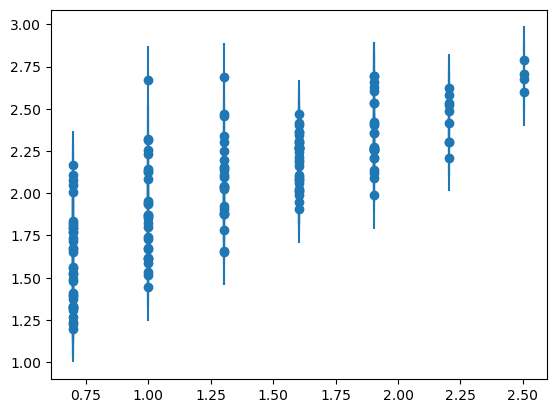

In [27]:
preds, errs = combine_predictions(target_virus_name='A/AUCKLAND/5/96',
                                  target_table_name='tableS14',
                                  source_table_names=['tableS13', 'tableS1', 'tableS3'],
                                  comparison_combiner_dict=comparison_combiner_dict)

HAI_measurements, _, _ = comparison_combiner_dict['tableS13 TO tableS14']['A/AUCKLAND/5/96']['error_bar_data']
y = np.log10(preds)
yerr = [errs]*len(HAI_measurements)
plt.errorbar(HAI_measurements,y, yerr=yerr, fmt='o')

In [28]:
10**errs # hmmm, adding datasets did seem to improve error!. Funny

1.5869107787280048

# Chord Diagram
Check supplementary paper for a good description